In [1]:
import os 
import sys
import joblib
import pandas as pd 
import numpy as np   
import matplotlib.pyplot as plt 
import seaborn as sns 
import shap 

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)

if '../src' not in sys.path:
    sys.path.append('../src')

import config 

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk') 

In [2]:
X_test = pd.read_csv(os.path.join(config.PROCESSED_DATA_PATH, 'X_test.csv'))
y_test = pd.read_csv(os.path.join(config.PROCESSED_DATA_PATH, 'y_test.csv')).squeeze()


model_path = os.path.join(config.MODEL_PATH, 'final_lgbm_model.joblib')
model = joblib.load(model_path)

print("\nTest Data Shape:", X_test.shape)
print("Loaded Model:", model)


Test Data Shape: (10000, 22)
Loaded Model: LGBMClassifier(random_state=42)


In [3]:
y_pred =  model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("--- Final Model Performance on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"F1-Score (Macro): {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("-------------------------------------------")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Churned (0)', 'Churned (1)']))

--- Final Model Performance on Test Set ---
Accuracy:    0.9381
Precision:   0.8937
Recall:      0.8540
F1-Score (Macro): 0.9162
ROC AUC Score: 0.9829
-------------------------------------------

Classification Report:
                 precision    recall  f1-score   support

Not Churned (0)       0.95      0.97      0.96      7500
    Churned (1)       0.89      0.85      0.87      2500

       accuracy                           0.94     10000
      macro avg       0.92      0.91      0.92     10000
   weighted avg       0.94      0.94      0.94     10000



/tmp/ipykernel_614430/3476453922.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


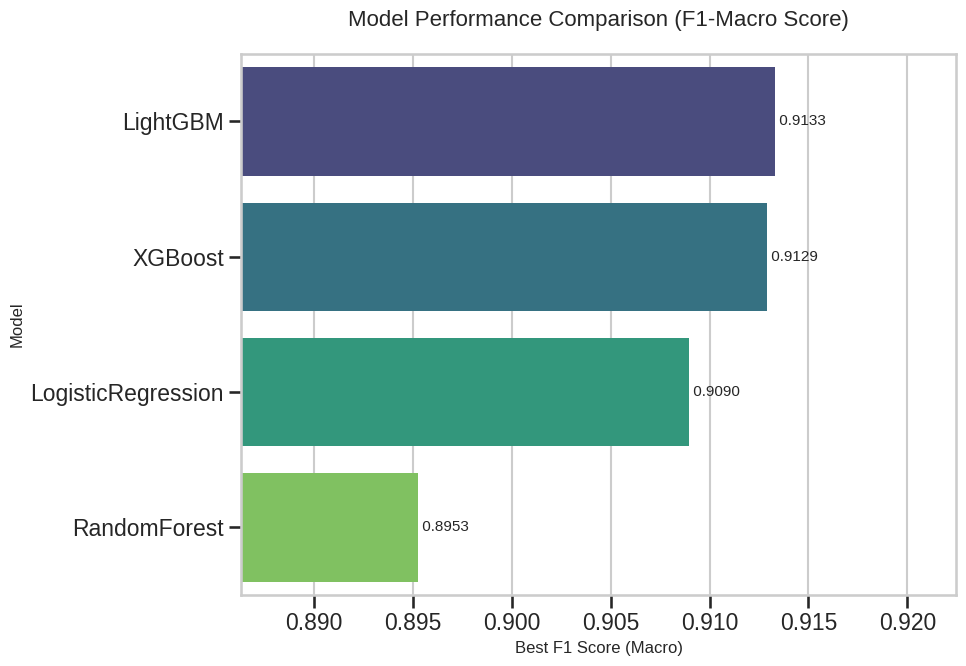

In [4]:
results_df = pd.read_csv(os.path.join(config.MODEL_PATH, 'f1_macro.csv'))
results_df = results_df.sort_values(by='Best Score (f1_macro)', ascending=False)

plt.figure(figsize=(10, 7))

barplot = sns.barplot(
    x='Best Score (f1_macro)', 
    y='Model', 
    data=results_df, 
    palette='viridis',
    orient='h'
)
plt.title('Model Performance Comparison (F1-Macro Score)', fontsize=16, pad=20)
plt.xlabel('Best F1 Score (Macro)', fontsize=12)
plt.ylabel('Model', fontsize=12)

plt.xlim(min(results_df['Best Score (f1_macro)']) * 0.99, max(results_df['Best Score (f1_macro)']) * 1.01)

for index, value in enumerate(results_df['Best Score (f1_macro)']):
    plt.text(value, index, f' {value:.4f}', va='center', fontsize=11)

figure_path = os.path.join(config.FIGURES_PATH, 'model_comparision.png')
plt.savefig(figure_path, dpi = 300, bbox_inches='tight')

plt.tight_layout()
plt.show()

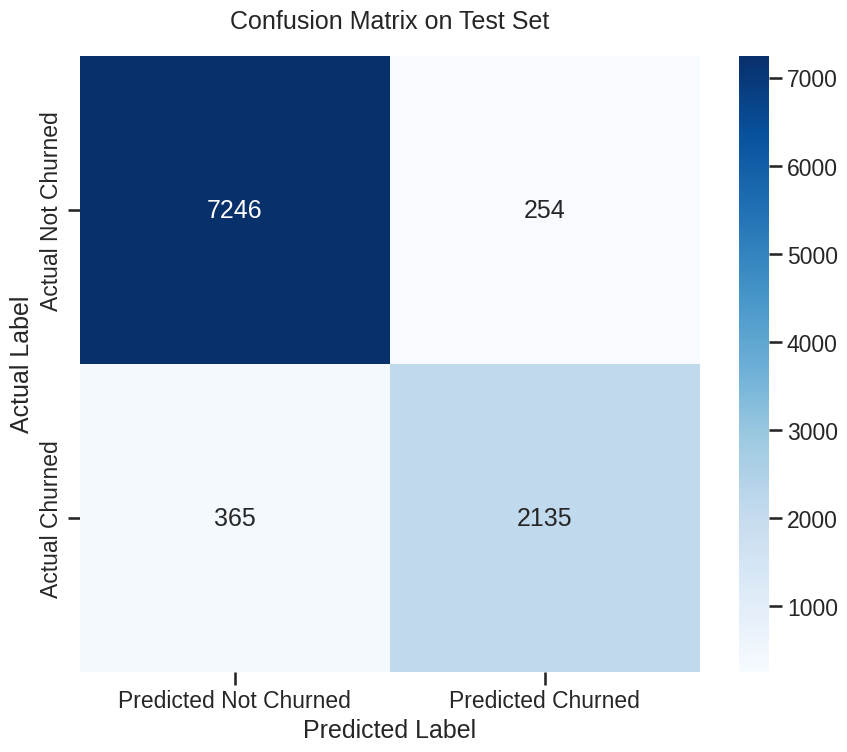

Confusion matrix saved to ../reports/figures/confusion_matrix.png


In [5]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=['Predicted Not Churned', 'Predicted Churned'], 
            yticklabels=['Actual Not Churned', 'Actual Churned'])

plt.title('Confusion Matrix on Test Set', fontsize=18, pad=20)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')


figure_path = os.path.join(config.FIGURES_PATH, 'confusion_matrix.png')
plt.savefig(figure_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"Confusion matrix saved to {figure_path}")

/tmp/ipykernel_614430/1684993888.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'importance', y= 'feature', data= feature_importance_df, palette='Set3')


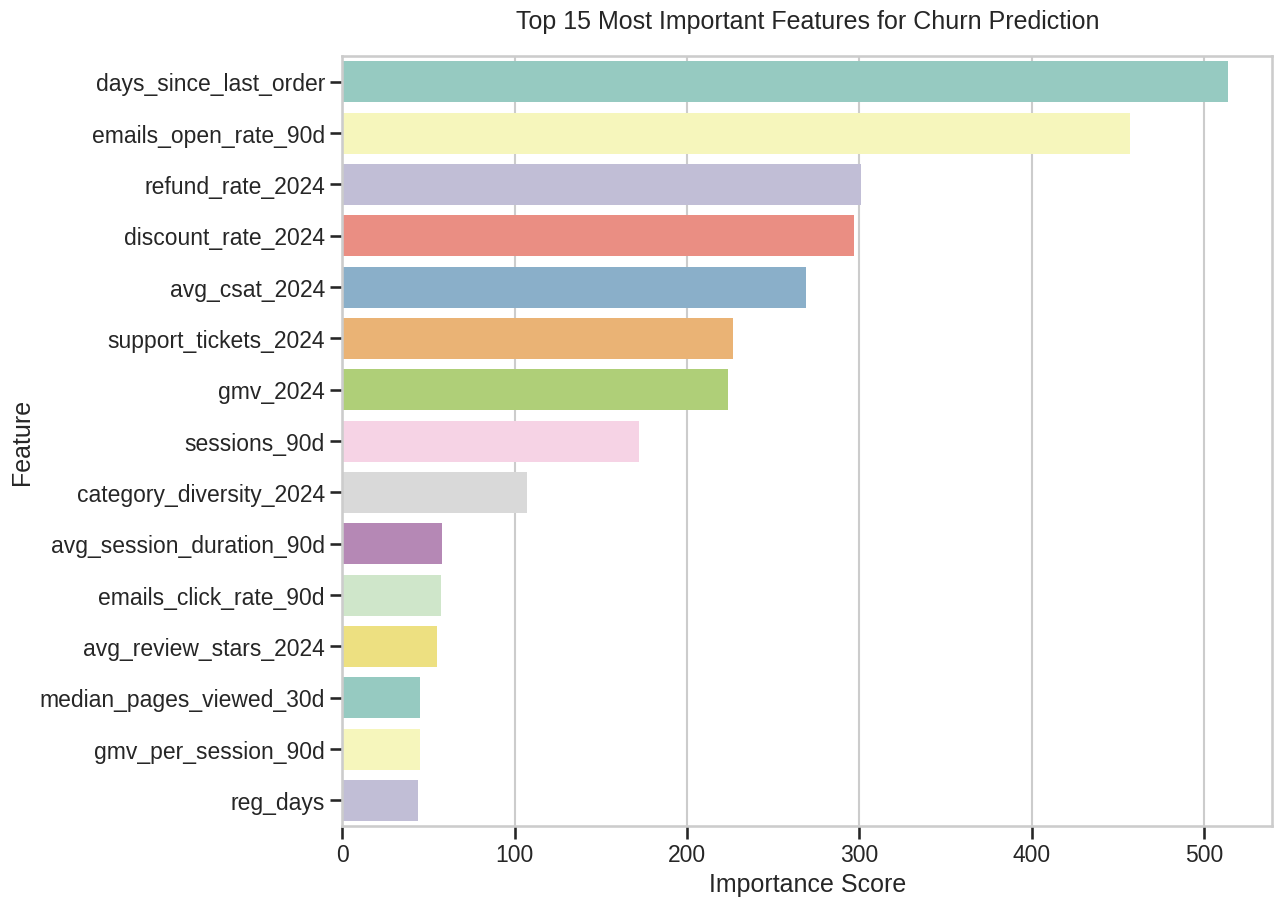

Feature importance plot saved to ../reports/figures/feature_importance.png


In [6]:
importances = model.feature_importances_
feature_names = X_test.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

feature_importance_df = feature_importance_df.sort_values(by = 'importance', ascending=False).head(15)

plt.figure(figsize=(12, 10))
sns.barplot(x = 'importance', y= 'feature', data= feature_importance_df, palette='Set3')
plt.title("Top 15 Most Important Features for Churn Prediction", fontsize= 18, pad =20)
plt.xlabel('Importance Score')
plt.ylabel('Feature')

figure_path = os.path.join(config.FIGURES_PATH, 'feature_importance.png')
plt.savefig(figure_path, dpi = 300, bbox_inches='tight')

plt.show()
print(f"Feature importance plot saved to {figure_path}")

/home/huychan/anaconda3/envs/huyy/lib/python3.10/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Generating SHAP summary plot...


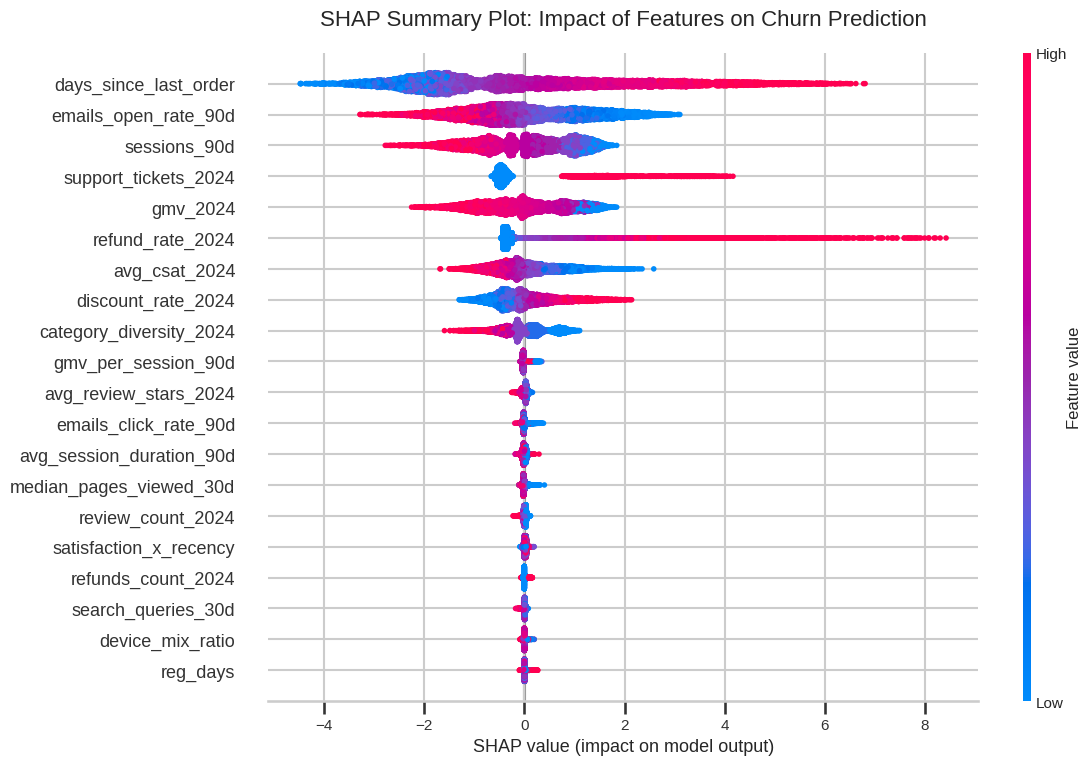

SHAP summary plot saved to ../reports/figures/shap_summary_plot.png


In [ ]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, X_test, show=False)

fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.title("Impact of Features on Churn Prediction", fontsize=16, pad=20)

plt.tight_layout()

figure_path = os.path.join(config.FIGURES_PATH, 'shap_summary_plot.png')
plt.savefig(figure_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"SHAP summary plot saved to {figure_path}")